## 1. Problem definition:
- Titanic  is based on the sinking of the ‘Unsinkable’ ship Titanic in the early 1912. The dataset 'train' provides information about multiple passengers, including their ages, sexes, sibling counts, embarkment points and whether or not they survived the disaster. Based on these features, I have tried to predict if an arbitrary passenger on Titanic would survive the sinking

### Approach
- Explore the given data set 
- Feature engineer the variables to be fit for the model
- Train the model 
- cross validate, if needed change the parameters
- calculate the test score 
- (deploy model)

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix

%matplotlib inline

In [2]:
df_train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

## 1.1 Split data set in test and train

In [3]:
x = df_train[['PassengerId', 'Pclass','Sex','Age','SibSp','Parch','Fare','Cabin','Embarked']]
y = df_train['Survived']

In [ ]:
#xtrain, xtest, ytrain, ytest = train_test_split(x,y, test_size=0.2, random_state=42)
#xtrain.shape, xtest.shape, ytrain.shape, ytest.shape

In [ ]:
#df_train = pd.concat([ytrain, xtrain], axis=1)
#df_train.head(), df_train.shape

In [ ]:
#df_test = pd.concat([ytest, xtest], axis=1)
#df_test.head(), df_test.shape

## 2. Explore data set
- and see implications on survival rate

### Survival by Age
- Generally younger passengers seem to have been more likely to survive the sinking of the titanic

In [ ]:
plt.subplot(1,2,1) # a rows and b columns and the cth plot from that
hist_sur = df_train[df_train.Survived == 1]['Age']
hist_sur.hist(bins=20)
plt.title('survived')
plt.subplot(1,2,2)
hist_not = df_train[df_train.Survived == 0]['Age']
hist_not.hist(bins=20)
plt.title('died')

### Survival by Gender
- men where far more likely to die on the titanic 

In [ ]:
table = df_train[['Sex','Survived','PassengerId']].groupby(['Survived','Sex'])['PassengerId'].count().unstack()
table1 = table.plot.bar()
plt.title('Survival by Gender')

### Survival by Pclass
- First class passengers were more likely to survive, while 3rd class passengers where more likely to die

In [ ]:
table2 = df_train[['Pclass','Survived','PassengerId']].groupby(['Survived','Pclass'])['PassengerId'].count().unstack()
table3 = table2.plot.bar()
plt.title('Survival by Pclass')

### Survival by Fare

In [ ]:
ax2 = sns.boxplot(x="Survived", y="Fare", 
                data=df_train)
ax2 = sns.stripplot(x="Survived", y="Fare",
                   data=df_train, jitter=True,
                   edgecolor="gray")
plt.title("Survival by Fare price",fontsize=12);

In [ ]:
table4 = df_train[['Embarked','Survived','PassengerId']].groupby(['Survived','Embarked'])['PassengerId'].count().unstack()
table5 = table4.plot.bar()
plt.title('Survival by port of embarkation')

### Multi feature visualisation 
- Gender split in plots for male and female
- Shows survival by Pclass and age of passenger

In [ ]:
grid = sns.FacetGrid(df_train, hue="Survived", col="Sex", margin_titles=True,
                  palette={1:"seagreen", 0:"red"})
grid = grid.map(plt.scatter, "Age", "Pclass",edgecolor="w").add_legend();

### Feature correlation to decide on usage in the model
- Looking at the row/column 'Survived', highest correclation with 'Pclass', 'Fare', 'Parch' and 'age'
- thus these will be used to train the model
- Sex is not yet a numerical value, so cannot be checked

In [ ]:
corr=df_train.corr() #["Survived"]
plt.figure(figsize=(10, 10))
sns.heatmap(corr, vmax=.8, linewidths=0.01,
            square=True,annot=True,cmap='Blues',linecolor="white")
plt.title('Correlation between features');

In [ ]:
df_train.corr()["Survived"]

## 3. Feature engineering of the dataset

### Check for missing values in the data set
- missing values age
- missing values in Cabin
- missing values in Embarked

In [4]:
df_train.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [5]:
test.isnull().sum()

PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64

In [6]:
#df_train.isnull().sum()
#sns.heatmap(df.isnull(), cbar = False).set_title("Missing values heatmap")

In [7]:
#df_train.nunique()

### Treating missing values in the data set
- Replace missing age values with mean of Pclass and Sex
- Replace missing Embarked port with Southhampton as most people embarked here and its only 2 missing rows

In [8]:
df_train['Age'] = df_train['Age'].fillna(df_train.groupby(['Pclass','Sex'])['Age'].transform('mean'))
df_train["Embarked"] = df_train["Embarked"].fillna('S')
df_train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [9]:
test['Age'] = test['Age'].fillna(test.groupby(['Pclass','Sex'])['Age'].transform('mean'))
test["Embarked"] = test["Embarked"].fillna('S')
test["Fare"] = test["Fare"].fillna(test.Fare.mean())
test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


Mapping string male and female to a binary value 0,1

In [10]:
mapping = {'male':0, 'female':1}
df_train = df_train.replace({'Sex':mapping})
df_train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",0,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",1,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",1,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",1,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",0,35.0,0,0,373450,8.0500,NaN,S


In [11]:
test = test.replace({'Sex':mapping})
test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",0,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",1,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",0,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",0,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",1,22.0,1,1,3101298,12.2875,NaN,S


Use one hot encoding to convert columns 'Embarked', 'Sex','Pclass' and attach at the end of the data frame

In [12]:
onehot_train = pd.get_dummies(df_train['Embarked'], prefix='Embarked_')
df_train2 = pd.concat([df_train, onehot_train], axis=1)
df_train2.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Embarked__C,Embarked__Q,Embarked__S
0,1,0,3,"Braund, Mr. Owen Harris",0,22.0,1,0,A/5 21171,7.2500,NaN,S,0,0,1
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",1,38.0,1,0,PC 17599,71.2833,C85,C,1,0,0
2,3,1,3,"Heikkinen, Miss. Laina",1,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,0,0,1
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",1,35.0,1,0,113803,53.1000,C123,S,0,0,1
4,5,0,3,"Allen, Mr. William Henry",0,35.0,0,0,373450,8.0500,NaN,S,0,0,1


In [13]:
onehot_test = pd.get_dummies(test['Embarked'], prefix='Embarked_')
test2 = pd.concat([test, onehot_test], axis=1)
test2.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Embarked__C,Embarked__Q,Embarked__S
0,892,3,"Kelly, Mr. James",0,34.5,0,0,330911,7.8292,NaN,Q,0,1,0
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",1,47.0,1,0,363272,7.0000,NaN,S,0,0,1
2,894,2,"Myles, Mr. Thomas Francis",0,62.0,0,0,240276,9.6875,NaN,Q,0,1,0
3,895,3,"Wirz, Mr. Albert",0,27.0,0,0,315154,8.6625,NaN,S,0,0,1
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",1,22.0,1,1,3101298,12.2875,NaN,S,0,0,1


Include 4 bins for column Age in the data set and append at the end

In [31]:
bins1 = pd.IntervalIndex.from_tuples([(0, 16), (16.01, 30), (30.01, 90)])
bins_train = pd.cut(df_train2['Age'], bins1)
bins_train = pd.get_dummies(bins_train, prefix='Age')
df_train3 = pd.concat([df_train2, bins_train], axis=1)
df_train3 = df_train3.rename(columns={1:'Pclass_1',2:'Pclass_2',3:'Pclass_3', 'Age_(0.0, 16.0]':'Age_0-16', 'Age_(16.01, 30.0]':'Age_16-30','Age_(30.01, 90.0]':'Age_30-90'})
df_train3.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Embarked__C,Embarked__Q,Embarked__S,Age_0-16,Age_16-30,Age_30-90
0,1,0,3,"Braund, Mr. Owen Harris",0,22.0,1,0,A/5 21171,7.2500,NaN,S,0,0,1,0,1,0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",1,38.0,1,0,PC 17599,71.2833,C85,C,1,0,0,0,0,1
2,3,1,3,"Heikkinen, Miss. Laina",1,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,0,0,1,0,1,0
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",1,35.0,1,0,113803,53.1000,C123,S,0,0,1,0,0,1
4,5,0,3,"Allen, Mr. William Henry",0,35.0,0,0,373450,8.0500,NaN,S,0,0,1,0,0,1


In [32]:
bins_test = pd.cut(test2['Age'], bins1)
bins_test = pd.get_dummies(bins_test, prefix='Age')
test3 = pd.concat([test2, bins_test], axis=1)
test3 = test3.rename(columns={1:'Pclass_1',2:'Pclass_2',3:'Pclass_3', 'Age_(0.0, 16.0]':'Age_0-16', 'Age_(16.01, 30.0]':'Age_16-30','Age_(30.01, 90.0]':'Age_30-90'})
test3.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Embarked__C,Embarked__Q,Embarked__S,Age_0-16,Age_16-30,Age_30-90
0,892,3,"Kelly, Mr. James",0,34.5,0,0,330911,7.8292,NaN,Q,0,1,0,0,0,1
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",1,47.0,1,0,363272,7.0000,NaN,S,0,0,1,0,0,1
2,894,2,"Myles, Mr. Thomas Francis",0,62.0,0,0,240276,9.6875,NaN,Q,0,1,0,0,0,1
3,895,3,"Wirz, Mr. Albert",0,27.0,0,0,315154,8.6625,NaN,S,0,0,1,0,1,0
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",1,22.0,1,1,3101298,12.2875,NaN,S,0,0,1,0,1,0


### Rechecking feature correlation to Survival rate
- Sex, Pclass, Fare, Embarked_C,Embarked_S,(I will add Embarked_Q), Parch and Age all have reasonable correlation to 'Survived'
- thus these features will be used to train the model

In [35]:
df_train3.corr()["Survived"].abs().sort_values(ascending=False)

Survived       1.000000
Sex            0.543351
Pclass         0.338481
Fare           0.257307
Embarked__C    0.168240
Embarked__S    0.149683
Age_0-16       0.121485
Age_16-30      0.113433
Parch          0.081629
Age            0.067485
Age_30-90      0.037731
SibSp          0.035322
PassengerId    0.005007
Embarked__Q    0.003650
Name: Survived, dtype: float64

In [36]:
df_train3.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked', 'Embarked__C',
       'Embarked__Q', 'Embarked__S', 'Age_0-16', 'Age_16-30', 'Age_30-90'],
      dtype='object')

In [37]:
test3.columns

Index(['PassengerId', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch',
       'Ticket', 'Fare', 'Cabin', 'Embarked', 'Embarked__C', 'Embarked__Q',
       'Embarked__S', 'Age_0-16', 'Age_16-30', 'Age_30-90'],
      dtype='object')

## 4. Train the model

In [54]:
x1 = df_train3[['Pclass', 'Sex', 'Age', 'SibSp',
       'Parch', 'Fare', 'Embarked__C',
       'Embarked__Q', 'Embarked__S']]
y1 = df_train3['Survived'] 
x_test = test3[['Pclass', 'Sex', 'Age', 'SibSp',
       'Parch', 'Fare', 'Embarked__C',
       'Embarked__Q', 'Embarked__S']]
#yt = df_test3['Survived']
#'Age_0-16', 'Age_16-30', 'Age_30-90'

In [90]:
# trial of different hyper parameters
rf_clf = RandomForestClassifier(criterion='entropy', max_depth=100, n_estimators=200, min_samples_split=5, 
    min_samples_leaf=1,
    max_features=7,
    oob_score=True,
    random_state=1,
    n_jobs=-1)
rf_clf.fit(x1,  np.ravel(y1))
#result = rf_clf.predict(x_test)

print("RF Accuracy: "+repr(round(rf_clf.score(x1, y1) * 100, 2)) + "%")

#result_rf=cross_val_score(rf_clf,x1,y1,cv=10,scoring='accuracy')
#print('The cross validated score for Random forest is:',round(result_rf.mean()*100,2))
#y_pred = cross_val_predict(rf_clf,x1,y1,cv=10)

#sns.heatmap(confusion_matrix(y1,y_pred),annot=True,fmt='3.0f',cmap=sns.cubehelix_palette(light=1, as_cmap=True))
#plt.title('Confusion_matrix for for RF', y=1.05, size=15)

RF Accuracy: 95.74%


In [91]:
y_test_pred = rf_clf.predict(x_test)

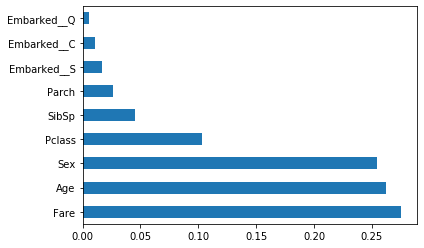

In [92]:
feat_importances = pd.Series(rf_clf.feature_importances_, index=['Pclass', 'Sex', 'Age', 'SibSp',
       'Parch', 'Fare', 'Embarked__C',
       'Embarked__Q', 'Embarked__S'])
feat_importances.nlargest(9).plot(kind='barh')

## 6. Create outputfile for kaggle

In [93]:
output = pd.DataFrame({'PassengerId': test.PassengerId, 'Survived': y_test_pred})
output.to_csv('saving_iceberg.csv', index=False)